In [155]:
import warnings
warnings.filterwarnings('ignore')

# %matplotlib widget
# %matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from sunpy.coordinates import sun
from astropy.constants import R_sun
from astropy.utils.data import download_file
import astropy.units as u
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from sunpy.coordinates import sun
from datetime import timedelta
import gzip
import urllib.request
from datetime import datetime
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sunpy.map import Map
from sunpy.sun import constants as const
from sunpy.coordinates import frames
from sunpy.coordinates import sun
import pfsspy
import pfsspy.tracing as tracing
from sunkit_instruments import suvi
# import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch, PercentileInterval
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('../../scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'
# savedir = '/home/mnedal/repos/dias_work'

Select the date and time of the observation

In [8]:
mydatetime = '2021-09-18T08:15:00'

mydate, mytime = mydatetime.split('T')
year, month, day = mydate.split('-')
hour, minute, second = mytime.split(':')

# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(f'CR: {cr}')

CR: 2248


In [9]:
# show the links of the GONG files
gong_url = f'https://gong2.nso.edu/oQR/zqs/{year}{month}/mrzqs{year[-2:]}{month}{day}/'
list_gong_links = myfuncs.find_links(url=gong_url)

# show what is in there
for i, link in enumerate(list_gong_links):
    print(i, link)

0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /oQR/zqs/202109/
5 mrzqs210918t0014c2248_027.fits.gz
6 mrzqs210918t0104c2248_026.fits.gz
7 mrzqs210918t0204c2248_026.fits.gz
8 mrzqs210918t0314c2248_025.fits.gz
9 mrzqs210918t0334c2248_025.fits.gz
10 mrzqs210918t0504c2248_024.fits.gz
11 mrzqs210918t0604c2248_024.fits.gz
12 mrzqs210918t0704c2248_023.fits.gz
13 mrzqs210918t0814c2248_022.fits.gz
14 mrzqs210918t0914c2248_022.fits.gz
15 mrzqs210918t1014c2248_021.fits.gz
16 mrzqs210918t1104c2248_021.fits.gz
17 mrzqs210918t1214c2248_020.fits.gz
18 mrzqs210918t1304c2248_020.fits.gz
19 mrzqs210918t1404c2248_019.fits.gz
20 mrzqs210918t1514c2248_019.fits.gz
21 mrzqs210918t1614c2248_018.fits.gz
22 mrzqs210918t1714c2248_017.fits.gz
23 mrzqs210918t1814c2248_017.fits.gz
24 mrzqs210918t1904c2248_016.fits.gz
25 mrzqs210918t2014c2248_016.fits.gz
26 mrzqs210918t2114c2248_015.fits.gz
27 mrzqs210918t2204c2248_015.fits.gz
28 mrzqs210918t2304c2248_014.fits.gz


Choose which file to download

In [11]:
gong_file_index = 13
gong_filename = list_gong_links[gong_file_index]

# make sure there is a data diretory to store the files
os.makedirs(f'{data_dir}/GONG', exist_ok=True)
print(f'{data_dir}/GONG/{gong_filename}')

/home/mnedal/data/GONG/mrzqs210918t0814c2248_022.fits.gz


Load a GONG magnetic field map at the specified datetime

In [12]:
if not os.path.exists(f'{data_dir}/GONG/{gong_filename[:-3]}') and not os.path.exists(f'{data_dir}/GONG/{gong_filename}'):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=f'{data_dir}/GONG/{gong_filename}')

if not os.path.exists(f'{data_dir}/GONG/{gong_filename[:-3]}'):
    with gzip.open(f'{data_dir}/GONG/{gong_filename}', 'rb') as f:
        with open(f'{data_dir}/GONG/{gong_filename[:-3]}', 'wb') as g:
            g.write(f.read())

In [170]:
# make a sunpy map of the file
gong_map = Map(f'{data_dir}/GONG/{gong_filename[:-3]}')

# fix a bug in the GONG map file
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

## Load the corresponding AIA map

In [16]:
start_time = pd.Timestamp(gong_map.meta['date'])
end_time   = pd.Timestamp(gong_map.meta['date']) + timedelta(minutes=1)

aia_map = myfuncs.load_aia_single(data_dir=data_dir, start=start_time, end=end_time, level=1, channel=193)[0]

AIA 193A image 0 is loaded


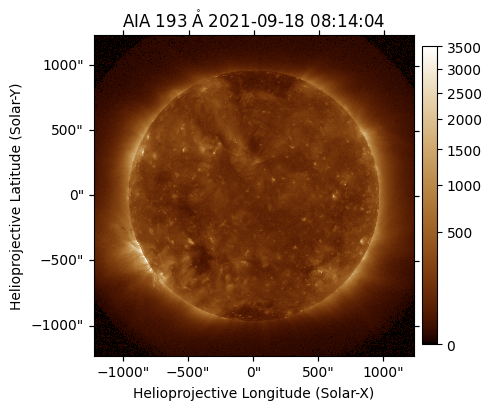

In [17]:
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3.5e3, stretch=SqrtStretch())

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection=aia_map)
img = aia_map.plot(axes=ax)
plt.colorbar(img, shrink=0.7, pad=0.02)
ax.grid(False)
fig.tight_layout()
plt.show()

## The PFSS Model

* The Sun’s magnetic field is complex and highly dynamic, particularly in the corona.
* Near the Sun’s surface, the magnetic field lines are closed, forming loops.
* As you move further from the Sun, these loops open up and the magnetic field becomes more radial.
* The PFSS model helps simplify this complex structure by assuming that at a certain distance from the Sun, called the source surface, the magnetic field transitions to this radial state.
* Below the source surface, the model assumes the magnetic field is potential, meaning it is derived from a scalar potential and has no electric currents (it is curl-free).
* This is an approximation that helps in solving the magnetic field equations more easily.
* The source surface is typically set at a radius of about 2.5 $R_\odot$.
* This value is chosen because it roughly corresponds to where solar wind starts to dominate, stretching the magnetic field lines into a radial configuration.
* The parameter `r`, which is set to 1.2 $R_\odot$ represents the radial distance from the center of the Sun at which you are starting the tracing of magnetic field lines.
* The value 1.2 is commonly chosen because it lies in the lower corona, where the magnetic field structure is still influenced by the solar surface but is starting to show the effects of the solar wind and the transition to more open field structures.
* In the PFSS model, the magnetic field is computed between the Sun’s surface and the source surface (often at 2.5 $R_\odot$).
* By setting `r` to 1.2 $R_\odot$, you are examining the magnetic field lines within this region, but closer to the Sun’s surface rather than at the outer boundary.

In [33]:
# find where is the Earth LOS on GONG map
hp_lon = 0*u.arcsec
hp_lat = np.linspace(-970, 970, 30)*u.arcsec

# Make a 2D grid from these 1D points
lon, lat = np.meshgrid(hp_lon, hp_lat)
earth_los = SkyCoord(lon.ravel(), lat.ravel(), frame=aia_map.coordinate_frame)
los_lon = sun.L0(time=aia_map.meta['date-obs']).value
print(f'Carrington longitude: {los_lon}')

Carrington longitude: 82.40055552690069


In [171]:
# The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where rho = ln(r), 
# and r is the standard spherical radial coordinate.
# We need to define the number of grid points in rho, and the source surface radius.
# From the boundary condition, number of radial grid points, and source surface, 
# we now construct an `Input` object that stores this information.
# Using the `Input` object, plot the input photospheric magnetic field.
rss = 2.5   # source surface radius
nrho = 50 # number of rho grid points
r = 1.2*const.radius # The height at which field line tracing is started, in solar radii

pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

In [181]:
# Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from. 
# These coordinates are defined in the helioprojective frame of the AIA image.
num_footpoints = 20
lat = np.linspace(np.radians(-85), np.radians(85), num_footpoints, endpoint=False)
lon = np.linspace(np.radians(-30), np.radians(180), num_footpoints, endpoint=False)

# # ONLY AT THE EARTH LOS
# lat = np.linspace(np.radians(-85), np.radians(85), num_footpoints, endpoint=False)
# lon = np.linspace(np.radians(los_lon-5), np.radians(los_lon+5), 5, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad

# Make a 2D grid from these 1D points
seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)

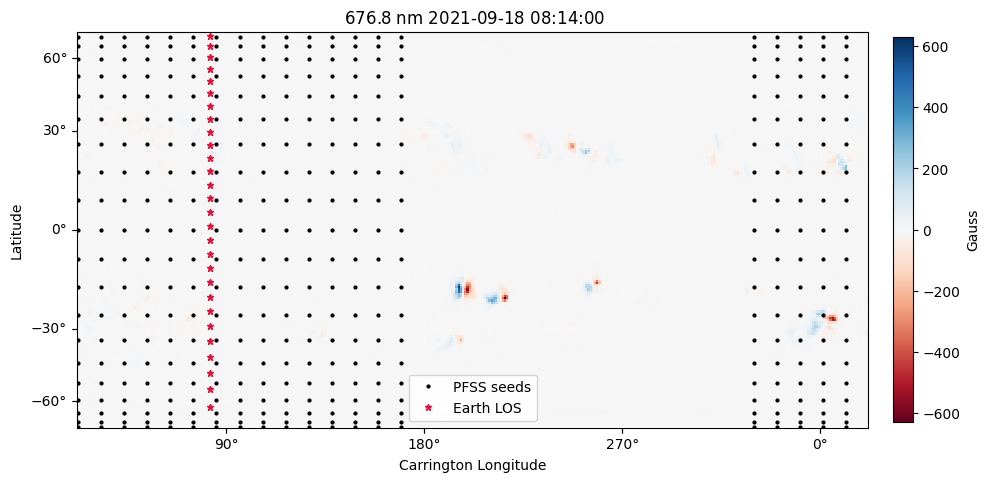

In [182]:
# Plot the magnetogram and the seed footpoints
m = pfss_in.map

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2, label='PFSS seeds')
ax.plot_coord(earth_los, color='crimson', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.legend(loc='best')
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
fig.tight_layout()
plt.show()

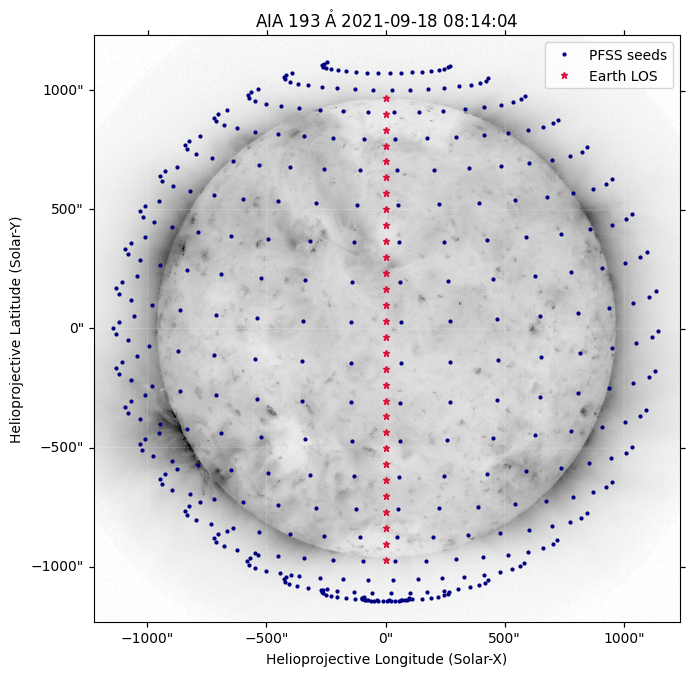

In [183]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='gray_r')
ax.plot_coord(seeds, color='navy', marker='o', linewidth=0, markersize=2, label='PFSS seeds')
ax.plot_coord(earth_los, color='crimson', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [184]:
# tracer = tracing.FortranTracer(max_steps=20000, step_size=1)
tracer = tracing.FortranTracer()
# tracer = tracing.PythonTracer()
flines = tracer.trace(seeds, pfss_out)

Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from.

These coordinates are defined in the helioprojective frame of the SUVI image.

Plotting the field lines: 100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [04:19<00:00,  9.25it/s]


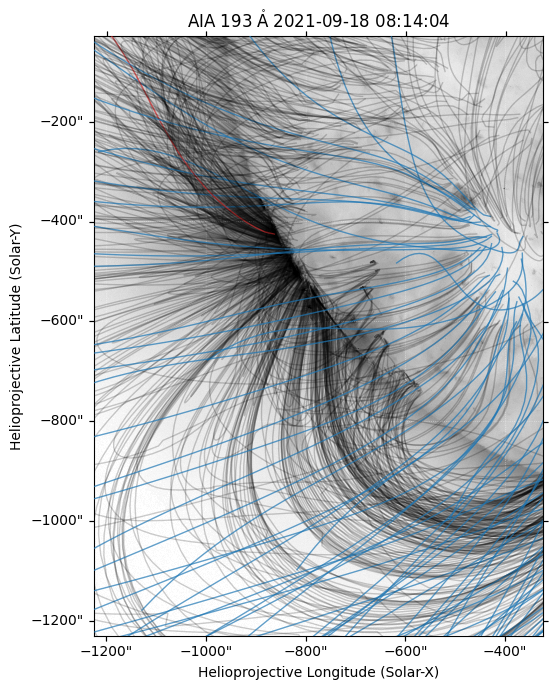

In [51]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='gray_r')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for fline in flines:
        color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(fline.polarity)
        if fline.polarity == 0:
            alpha = 0.2
        else:
            alpha = 0.7
        ax.plot_coord(fline.coords, alpha=alpha, color=color, linewidth=1)
        pbar.update(1)

# ax.set_xlim(left=0, right=int(aia_map.dimensions.x.value))
# ax.set_ylim(bottom=0, top=int(aia_map.dimensions.y.value))
ax.set_xlim(left=0, right=1500)
ax.set_ylim(bottom=0, top=2000)
fig.tight_layout()
plt.show()

In [185]:
# This is a NumPy array with the magnetic field data
data = gong_map.data

# Define clip interval in terms of percentiles
clip_interval = [1, 99] * u.percent

# Calculate the clipping values
lower_clip, upper_clip = np.percentile(data, clip_interval.value)

# Define grid dimensions based on the data shape
nx, ny = data.shape
x = np.arange(0, nx)
y = np.arange(0, ny)
x, y = np.meshgrid(x, y)

# Convert to a PyVista StructuredGrid
grid = pv.StructuredGrid(x, y, np.zeros_like(x))  # 2D grid in the XY plane
grid['magnetic_field'] = data.flatten(order='F')  # Add the data as a cell array

# Define your geographic coordinates
latitude = 0
longitude = sun.L0(time=aia_map.meta['date-obs'])
x, y, z = myfuncs.geo_to_cartesian(latitude, longitude)

# Define the separation distance
sphere_radius = 1
separation_distance = 1.5  # Distance from the sphere's surface to the arrow's starting point

# Define the original direction vector of the arrow
original_direction = np.array([x, -y, z])

# Normalize the direction vector to get the unit vector
direction = original_direction / np.linalg.norm(original_direction)

# Calculate the total distance to offset the arrow's starting point from the sphere center
total_offset = sphere_radius + separation_distance

# Calculate the new origin for the arrow, keeping the same direction but offset from the sphere
adjusted_origin = direction * total_offset

# Define the arrow length
arrow_length = 0.5

# Calculate the scaled direction for the arrow
scaled_direction = direction * arrow_length

In [186]:
plotter = SunpyPlotter()
plotter.plot_map(gong_map,
                 cmap='RdBu_r', # RdYlBu_r
                 # clip_interval=[1, 99]*u.percent,
                 show_scalar_bar=False
                )
# Add the arrow to the plotter with the adjusted origin
plotter.plotter.add_arrows(adjusted_origin, scaled_direction, color='black', mag=1)

# Plotting the field lines
plotter.plot_field_lines(flines, opacity=0.7)

# Add invisible data mesh to show the colorbar (workaround)
plotter.plotter.add_mesh(grid,
                         # clim=[lower_clip, upper_clip],
                         cmap='RdBu_r', opacity=0, show_scalar_bar=False)
plotter.plotter.add_scalar_bar(
    title=gong_map.meta['bunit'],
    interactive=True,
    # vertical=False,
    title_font_size=30,
    label_font_size=30,
    # outline=True
)
plotter.plotter.set_background(color='#54596d')
plotter.plotter.add_axes(interactive=True, line_width=5, color='black',
                         labels_off=True,
                         x_color='red', y_color='green', z_color='blue')
camera_coord = SkyCoord(
    0 * u.deg,
    0 * u.deg,
    8 * R_sun,
    frame=frames.HeliographicStonyhurst,
    obstime=gong_map.date)
plotter.set_camera_coordinate(camera_coord)
# plotter.plotter.view_xy() # view_xy, view_xz, view_yx, view_yz, view_zx, view_zy
# plotter.show(window_size=[400,400], cpos='yz', jupyter_backend='panel')
plotter.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Make a movie

In [187]:
plotter = SunpyPlotter()
plotter.plot_map(gong_map,
                 cmap='RdBu_r', # RdYlBu_r
                 show_scalar_bar=False
                )
# Add the arrow to the plotter with the adjusted origin
plotter.plotter.add_arrows(adjusted_origin, scaled_direction, color='black', mag=1)

# Plotting the field lines
plotter.plot_field_lines(flines, opacity=0.4)

# Add invisible data mesh to show the colorbar (workaround)
plotter.plotter.add_mesh(grid, cmap='RdBu_r', opacity=0, show_scalar_bar=False)
plotter.plotter.add_scalar_bar(
    title=gong_map.meta['bunit'],
    interactive=True,
    title_font_size=30,
    label_font_size=30,
)
plotter.plotter.set_background(color='#54596d')
plotter.plotter.add_axes(interactive=True, line_width=5, color='black',
                         labels_off=True,
                         x_color='red', y_color='green', z_color='blue')
camera_coord = SkyCoord(
    0 * u.deg,
    0 * u.deg,
    10 * R_sun,
    frame=frames.HeliographicStonyhurst,
    obstime=gong_map.date)
plotter.set_camera_coordinate(camera_coord)

plotter.plotter.open_movie('3d_plot_rotation.mp4') # Open a movie file

n_frames = 360 # Number of frames for a full rotation (360 degrees)

# Rotate the camera around the object in a circular path
for i in range(n_frames):
    # Set the camera position
    # plotter.plotter.camera_position = 'xz'  # Start from this plane view
    # plotter.plotter.camera.azimuth = i  # Rotate the camera azimuthally

    # Rotate the camera azimuthally around the z-axis
    plotter.plotter.camera_position = plotter.plotter.camera_position  # Keep the current camera position
    plotter.plotter.camera.azimuth += 1  # Increment azimuth to rotate around
    plotter.plotter.write_frame() # Write the frame to the movie

plotter.plotter.close() # Close the movie and clean up

In [ ]:

# This is a NumPy array with the magnetic field data
data = gong_map.data

# Define clip interval in terms of percentiles
clip_interval = [1, 99] * u.percent

# Calculate the clipping values
lower_clip, upper_clip = np.percentile(data, clip_interval.value)

# Define grid dimensions based on the data shape
nx, ny = data.shape
x = np.arange(0, nx)
y = np.arange(0, ny)
x, y = np.meshgrid(x, y)

# Convert to a PyVista StructuredGrid
grid = pv.StructuredGrid(x, y, np.zeros_like(x))  # 2D grid in the XY plane
grid['magnetic_field'] = data.flatten(order='F')  # Add the data as a cell array

# Define the LOS coordinates
longitude = sun.L0(time=aia_map.meta['date-obs'])
earth_los = SkyCoord(lon=longitude, lat=0*u.deg, frame=gong_map.coordinate_frame)

# Define the separation distance
sphere_radius = 1
separation_distance = 1  # Distance from the sphere's surface to the arrow's starting point

# Define the original direction vector of the arrow
original_direction = np.array([x, y, z])

# Normalize the direction vector to get the unit vector
direction = original_direction / np.linalg.norm(original_direction)

# Calculate the total distance to offset the arrow's starting point from the sphere center
total_offset = sphere_radius + separation_distance

# Calculate the new origin for the arrow, keeping the same direction but offset from the sphere
adjusted_origin = direction * total_offset

# Define the arrow length
arrow_length = 0.5

# Calculate the scaled direction for the arrow
scaled_direction = direction * arrow_length



plotter = SunpyPlotter()
plotter.plot_map(gong_map,
                 cmap='RdBu_r', # RdYlBu_r
                 # clip_interval=[1, 99]*u.percent,
                 show_scalar_bar=False
                )
# Add the arrow to the plotter with the adjusted origin
plotter.plotter.add_arrows(adjusted_origin, scaled_direction, color='black', mag=1)

# Plotting the field lines
plotter.plot_field_lines(flines)

# Add invisible data mesh to show the colorbar (workaround)
plotter.plotter.add_mesh(grid,
                         # clim=[lower_clip, upper_clip],
                         cmap='RdBu_r', opacity=0, show_scalar_bar=False)
plotter.plotter.add_scalar_bar(
    title=gong_map.meta['bunit'],
    interactive=True,
    vertical=False,
    title_font_size=35,
    label_font_size=30,
    outline=True
)
plotter.plotter.set_background(color='#54596d')
plotter.plotter.add_axes(interactive=True, line_width=5, color='black',
                         labels_off=True,
                         x_color='red', y_color='green', z_color='blue')
camera_coord = SkyCoord(
    0 * u.deg,
    0 * u.deg,
    5 * R_sun,
    frame=frames.HeliographicStonyhurst,
    obstime=gong_map.date)
plotter.set_camera_coordinate(camera_coord)
plotter.show()

In [102]:
origin, direction, scaled_direction

(array([0.13224678, 0.99121682, 0.        ]),
 array([0.13224678, 0.99121682, 0.        ]),
 array([0.06612339, 0.49560841, 0.        ]))

In [92]:
# from astropy.constants import R_sun
# from sunkit_pyvista import SunpyPlotter
# import pyvista as pv
# pv.set_jupyter_backend('html') # static, client, server, trame, html
# pv.start_xvfb()

# plotter = SunpyPlotter()
# plotter.plot_map(gong_map, cmap='RdYlBu_r', # hmimag
#                  clip_interval=[1, 99]*u.percent,
#                  show_scalar_bar=False
#                 )
# plotter.plotter.add_scalar_bar(
#     title=gong_map.meta['bunit'],
#     interactive=True
# )
# # # Plotting the field lines
# # plotter.plot_field_lines(flines,
# #                          # color_func=my_fline_color_func
# #                         )
# plotter.plotter.add_axes(interactive=True, line_width=5, color='black',
#                          x_color='red', y_color='green', z_color='blue')
# plotter.plotter.set_background(color='#54596d')
# camera_coord = SkyCoord(
#     0 * u.deg,
#     0 * u.deg,
#     5 * R_sun,
#     frame=frames.HeliographicStonyhurst,
#     obstime=gong_map.date)
# plotter.set_camera_coordinate(camera_coord)
# # plotter.show(window_size=[400,400], cpos='yz', jupyter_backend='panel')
# plotter.show()

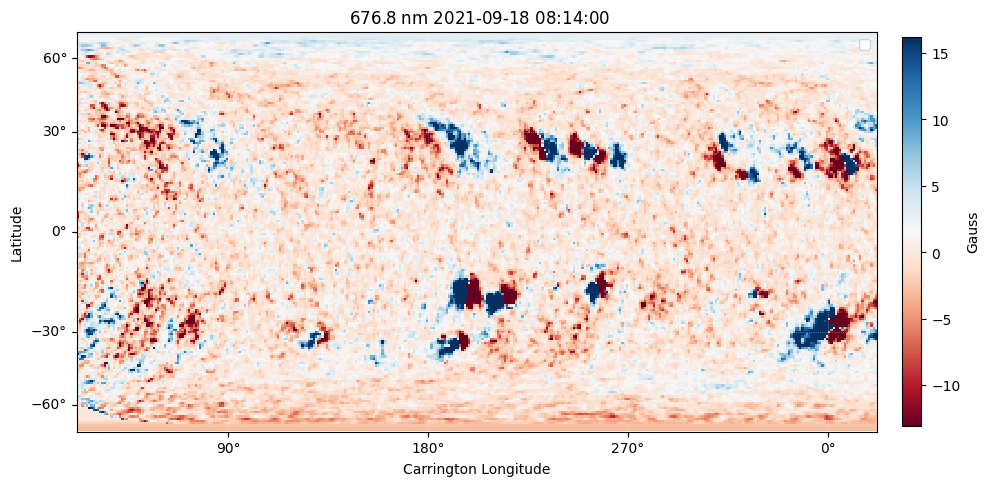

In [91]:
# test ...
m = pfss_in.map

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=m)
gon = m.plot(axes=ax, clip_interval=[1, 99]*u.percent)
ax.legend(loc='best')
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
fig.tight_layout()
plt.show()

Plotting the field lines: 100%|█████████████████████████| 2400/2400 [00:22<00:00, 104.65it/s]


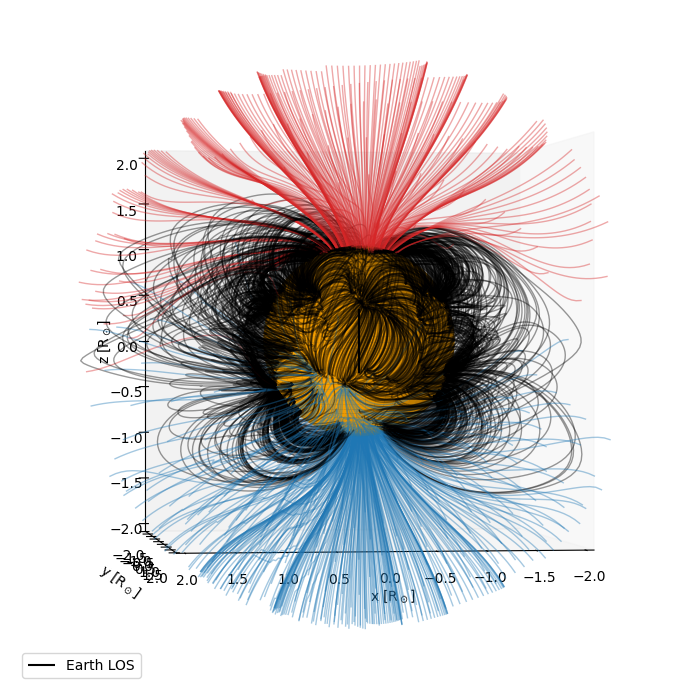

In [50]:
# Make a 3D plot

# %matplotlib inline
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

# draw the Sun
theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)
ax.plot_surface(x, y, z, color='orange', zorder=10)

# Define your geographic coordinates
latitude = 0
longitude = sun.L0(time=aia_map.meta['date-obs'])
x, y, z = myfuncs.geo_to_cartesian(latitude, longitude)
ax.quiver(0, 0, 0, x, y, z, length=4, arrow_length_ratio=0.3, color='k', zorder=15, label='Earth LOS')

with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
    for field_line in flines:
        color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        ax.plot3D(x_line, y_line, z_line, alpha=0.4, color=color, linewidth=1, zorder=20)
        pbar.update(1)

extent = 2
ax.set_xlim(-extent, extent)
ax.set_ylim(-extent, extent)
ax.set_zlim(-extent, extent)
ax.set_box_aspect([extent, extent, extent])
ax.grid(False)
ax.legend(loc='best')
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
ax.view_init(elev=0, azim=los_lon)
# ax.view_init(elev=0, azim=0)
fig.tight_layout()
plt.show()

Plotting the field lines in plot 4: 100%|███████████████| 2400/2400 [00:23<00:00, 101.23it/s]


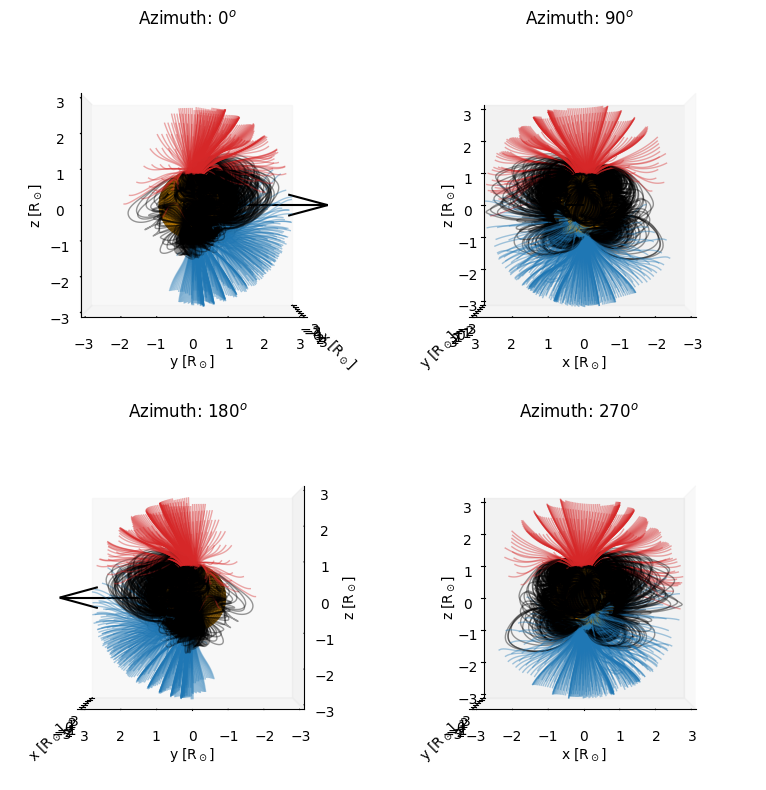

In [51]:
# Show different azimuth angles
%matplotlib inline

# Define your geographic coordinates
latitude = 0
longitude = sun.L0(time=aia_map.meta['date-obs'])
x, y, z = myfuncs.geo_to_cartesian(latitude, longitude)

# draw the Sun
theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
sun_x = np.sin(theta)*np.cos(phi) 
sun_y = np.sin(theta)*np.sin(phi) 
sun_z = np.cos(theta)

extent = 3
azimuth_angles = [0, 90, 180, 270]

fig = plt.figure(figsize=[8,8])

for i, angle in enumerate(azimuth_angles):
    ax = fig.add_subplot(2,2,i+1, projection='3d', computed_zorder=False)
    ax.plot_surface(sun_x, sun_y, sun_z, color='orange', zorder=10)
    ax.quiver(0, 0, 0, x, y, z, length=4, arrow_length_ratio=0.3, color='k', zorder=15, label='Earth LOS')
    
    with tqdm(total=len(flines), desc=f'Plotting the field lines in plot {i+1}') as pbar:
        for field_line in flines:
            color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(field_line.polarity)
            coords = field_line.coords
            coords.representation_type = 'cartesian'
            x_line = coords.x/const.radius
            y_line = coords.y/const.radius
            z_line = coords.z/const.radius
            ax.plot3D(x_line, y_line, z_line, alpha=0.4, color=color, linewidth=1, zorder=20)
            pbar.update(1)
    
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    ax.set_zlim(-extent, extent)
    ax.set_box_aspect([extent, extent, extent])
    ax.grid(False)
    ax.set_title(f'Azimuth: {angle}$^o$')
    # ax.legend(loc='best')
    for axis in 'xyz':
        getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
    ax.view_init(elev=0, azim=angle)

fig.tight_layout()
plt.show()